In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
 For example, here's several helpful packages to load

import numpy as np  linear algebra
import pandas as pd  data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from transformers import ViTModel
from sklearn.model_selection import KFold
from torchvision import transforms
from transformers.models.vit.modeling_vit import ViTEncoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
image_size = (224, 224)
batch_size = 16
epochs = 30
learning_rate = 0.0001
gamma = 0.5

dataset_path = "/kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset"

def strong_augmentations(prob=0.5):
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=prob),  
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=prob),  
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))], p=prob),  
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=prob), 
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=prob),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

transform = strong_augmentations()
def mixup_data(x, y, alpha=1.0):
    """MixUp Regularization"""
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def filter_dataset():
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    class_to_idx = dataset.class_to_idx
    monkeypox_idx = class_to_idx["Monkeypox"]
    for i in range(len(dataset.samples)):
        img_path, label = dataset.samples[i]
        dataset.samples[i] = (img_path, 0 if label == monkeypox_idx else 1)
    return dataset

dataset = filter_dataset()

In [ ]:
class BroadAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(BroadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, queries, keys, values):
        queries = torch.cat(queries, dim=1)
        keys = torch.cat(keys, dim=1)
        values = torch.cat(values, dim=1)
        attention_output, _ = self.attention(queries, keys, values)
        pooled_output = self.pool(attention_output.permute(0, 2, 1)).squeeze(-1)
        return pooled_output


In [ ]:
class B2MVITNet(nn.Module):
    def __init__(self, vit_model_name, num_classes, gamma=0.5):
        super(B2MVITNet, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name, output_attentions=True)
        self.hidden_size = self.vit.config.hidden_size
        self.num_layers = len(self.vit.encoder.layer)
        self.gamma = gamma

        self.mvit_encoder = ViTEncoder(self.vit.config)
        self.mvit_attention = nn.MultiheadAttention(embed_dim=self.hidden_size, num_heads=8)
        
        self.broad_attention = BroadAttention(hidden_size=self.hidden_size, num_layers=self.num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        deep_features = hidden_states[-1][:, 0, :]
        queries = [layer[:, 0, :].unsqueeze(1) for layer in hidden_states]
        broad_features = self.broad_attention(queries, queries, queries)


        mvit_outputs = self.mvit_encoder(hidden_states[-1])
        mvit_features = mvit_outputs.last_hidden_state[:, 0, :]

        combined_features = torch.cat((deep_features, self.gamma * broad_features + mvit_features), dim=1)
        logits = self.classifier(combined_features)
        return logits

kf = KFold(n_splits=5, shuffle=True, random_state=42)
class_names = dataset.classes
all_preds, all_targets = [], []
history = {
    "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [],
    "train_precision": [], "train_recall": [], "train_f1": [],
    "val_precision": [], "val_recall": [], "val_f1": []
}

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"\n Starting Fold {fold + 1}...")

    train_subset, val_subset = Subset(dataset, train_indices), Subset(dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = B2MVITNet("google/vit-base-patch16-224-in21k", num_classes=2, gamma=gamma).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_precision = precision_score(train_targets, train_preds, average='weighted')
        train_recall = recall_score(train_targets, train_preds, average='weighted')
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_precision"].append(train_precision)
        history["train_recall"].append(train_recall)
        history["train_f1"].append(train_f1)

        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_precision = precision_score(val_targets, val_preds, average='weighted')
        val_recall = recall_score(val_targets, val_preds, average='weighted')
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_precision)
        history["val_recall"].append(val_recall)
        history["val_f1"].append(val_f1)

        
        all_preds.extend(val_preds)
        all_targets.extend(val_targets)

        print(f" Epoch [{epoch + 1}/{epochs}] - Fold {fold + 1}")
        print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f}")
        print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")

    print(f"\n Fold {fold + 1} complete!\n" + "="*50)

print(f"\nTotal predictions collected: {len(all_preds)}")
print(f"Total targets collected: {len(all_targets)}")




 Starting Fold 1...


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


 Epoch [1/30] - Fold 1
 Train Loss: 0.4679 | Train Acc: 0.8523 | Precision: 0.8513 | Recall: 0.8523 | F1: 0.8517
 Val Loss:   0.7725 | Val Acc:   0.8571 | Precision: 0.8873 | Recall: 0.8571 | F1: 0.8576
 Epoch [2/30] - Fold 1
 Train Loss: 0.2305 | Train Acc: 0.9318 | Precision: 0.9316 | Recall: 0.9318 | F1: 0.9317
 Val Loss:   0.2343 | Val Acc:   0.9416 | Precision: 0.9446 | Recall: 0.9416 | F1: 0.9410
 Epoch [3/30] - Fold 1
 Train Loss: 0.1071 | Train Acc: 0.9610 | Precision: 0.9610 | Recall: 0.9610 | F1: 0.9609
 Val Loss:   0.1688 | Val Acc:   0.9610 | Precision: 0.9610 | Recall: 0.9610 | F1: 0.9610
 Epoch [4/30] - Fold 1
 Train Loss: 0.0909 | Train Acc: 0.9773 | Precision: 0.9773 | Recall: 0.9773 | F1: 0.9772
 Val Loss:   0.5142 | Val Acc:   0.9026 | Precision: 0.9209 | Recall: 0.9026 | F1: 0.9032
 Epoch [5/30] - Fold 1
 Train Loss: 0.0989 | Train Acc: 0.9724 | Precision: 0.9724 | Recall: 0.9724 | F1: 0.9724
 Val Loss:   0.7162 | Val Acc:   0.8961 | Precision: 0.9049 | Recall: 0.896

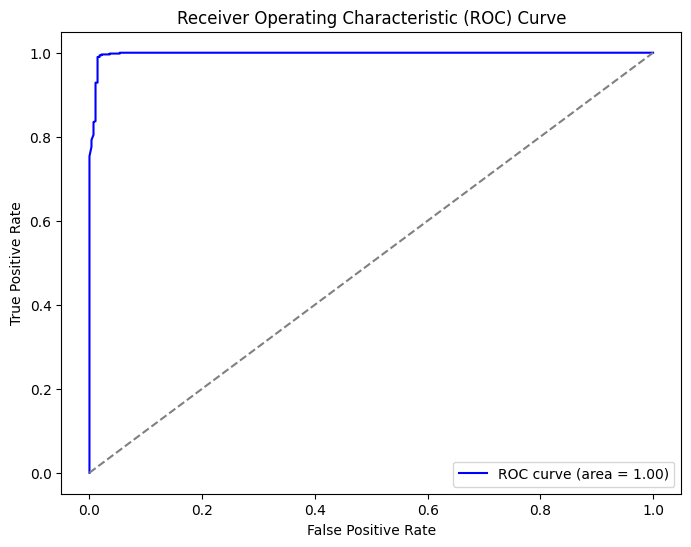

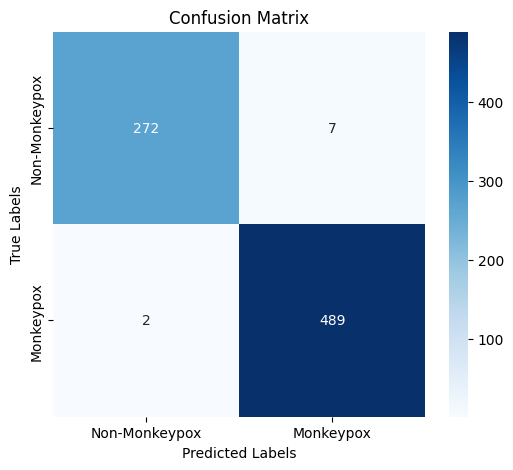

In [ ]:

import torch.nn.functional as F
import itertools

y_true_all, y_pred_all = [], []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    train_subset, val_subset = Subset(dataset, train_indices), Subset(dataset, val_indices)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    fold_y_true, fold_y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            fold_y_true.extend(labels.cpu().numpy())
            fold_y_pred.extend(probabilities)
    
    y_true_all.extend(fold_y_true)
    y_pred_all.extend(fold_y_pred)

fpr, tpr, _ = roc_curve(y_true_all, y_pred_all)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

threshold = 0.5  
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_all]
conf_matrix = confusion_matrix(y_true_all, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Monkeypox', 'Monkeypox'], yticklabels=['Non-Monkeypox', 'Monkeypox'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

